# Evaluation pipeline of fully recurrent NN - RDN aggregated hourly load

In [14]:
import torch
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from inference import darts_block_n_step_ahead_forecast
from preprocessing import get_time_covariates
import matplotlib.pyplot as plt

## Initial settings and data loading

In [15]:
# val / test set start dates
cut_date_val = '20190901'
cut_date_test = '20191201'

# load timeseries
series = TimeSeries.from_csv('load_60min.csv', index_col=0, parse_dates=True, freq='H')
series.describe()

component,Load
count,17520.000000
mean,23117.594199
std,4001.976016
min,14176.213388
25%,19676.528008
50%,23011.595927
75%,26112.905999
max,34885.779879


## Preprocessing
in this section timeseries is split to train / val / test and is normalised. Additionally time variables are also modeled as shown in the plot. The model requires these variables as input to function.

[2021-11-17 15:33:27,263] WARNING | darts.timeseries | Number of components is larger than 10 (11). Plotting only the first 10 components.


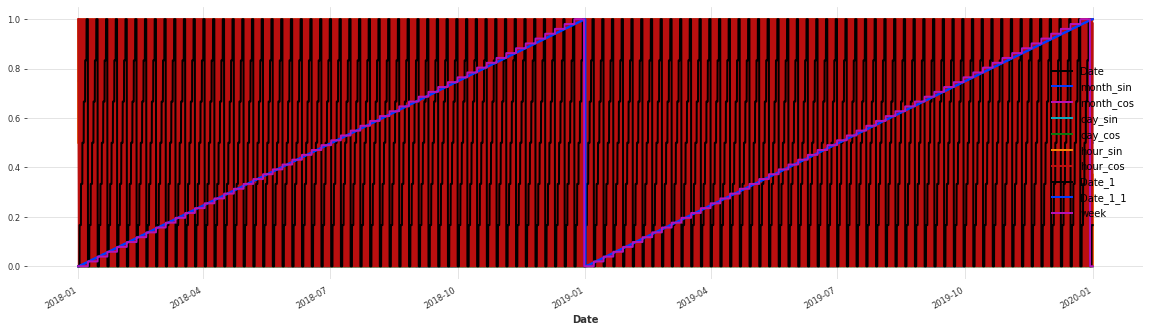

In [16]:
# Train / Test split
train, val = series.split_before(pd.Timestamp(cut_date_val))
val, test = val.split_before(pd.Timestamp(cut_date_test))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
scaler_ts = Scaler()

train_scaled = scaler_ts.fit_transform(train)
val_scaled = scaler_ts.transform(val)
test_scaled = scaler_ts.transform(test)
series_scaled = scaler_ts.transform(series)

# create month and year covariate series
time_covariates = get_time_covariates(series_scaled)

# scale them between 0 and 1:
scaler_cov = Scaler()
time_covariates = scaler_cov.fit_transform(time_covariates)

# split in train/validation sets:
cov_train, cov_val = time_covariates.split_before(pd.Timestamp(cut_date_val))
cov_val, cov_test = cov_val.split_before(pd.Timestamp(cut_date_test))
plt.figure(figsize=(20,5))
time_covariates.plot()

## Load best model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
best_model = torch.load('model_best_40.pth.tar', map_location=device)
best_model.device = device

## Inference and evaluation
Here we implement 8 forecasting iterations each one of forecasting horizon 3. Every 3 predictions the model gets updated with the ground truth of the previous block instead of just using its own output. The total forecasting horizon with this process ends up to 24h. This function can be run for any combination of block_n_steps, n_blocks as long as their product is smaller than 24*31  which is the size of the test set. (December 2019)

100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


MAPE = 6.26%


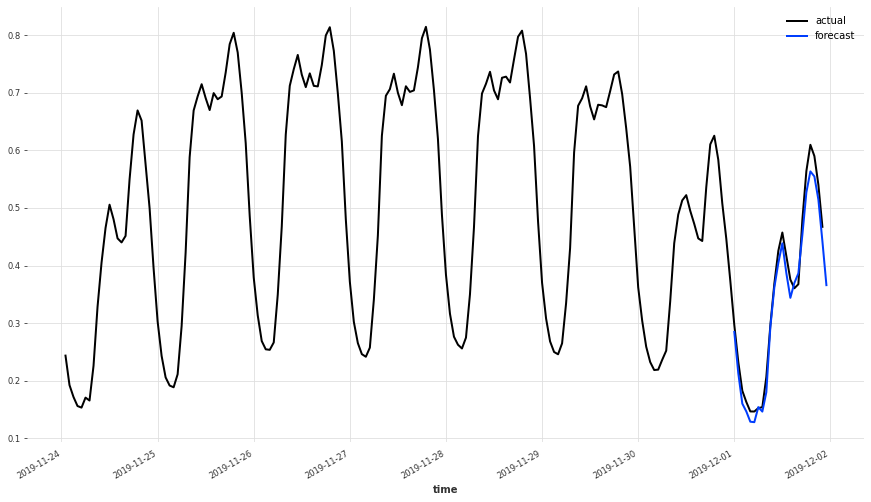

In [9]:
mape, pred = darts_block_n_step_ahead_forecast(model=best_model,
                                         history=val_scaled,
                                         test=test_scaled,
                                         block_n_steps=3,
                                         n_blocks=8,
                                         future_covariates=time_covariates,
                                         path_to_save_eval=None)


### Show predictions

In [17]:
# inverse transform normalized predictions
prediction = scaler_ts.inverse_transform(pred)
# show predictions
print(prediction)

<TimeSeries (DataArray) (time: 24, component: 1, sample: 1)>
array([[[20074.0667222 ]],

       [[18587.78286647]],

       [[17498.92853637]],

       [[17217.73789957]],

       [[16849.44584812]],

       [[16832.35255074]],

       [[17373.70282967]],

       [[17212.38895453]],

       [[17908.24719839]],

       [[20245.25638054]],

...

       [[21298.53145171]],

       [[21833.29817805]],

       [[22179.62625063]],

       [[23565.80981311]],

       [[25088.64029474]],

       [[25840.22439853]],

       [[25658.92670137]],

       [[24823.0549216 ]],

       [[23335.34525138]],

       [[21754.64181757]]])
Coordinates:
  * time       (time) datetime64[ns] 2019-12-01 ... 2019-12-01T23:00:00
  * component  (component) object 'Load'
Dimensions without coordinates: sample
